# CVSS-BERT

This notebook describes the code corresponding to the following paper:

M. R. Shahid and H. Debar , "CVSS-BERT: Explainable Natural Language Processing to Determine the Severity of a Computer Security Vulnerability from its Description," *2021 20th IEEE International Conference on Machine Learning and Applications (ICMLA)*, 2021.

**Abstract:** When a new computer security vulnerability is publicly disclosed, only a textual description of it is available. Cybersecurity experts later provide an analysis of the severity of the vulnerability using the Common Vulnerability Scoring System (CVSS). Specifically, the different characteristics of the vulnerability are summarized into a vector (consisting of a set of metrics), from which a severity score is computed. However, because of the high number of vulnerabilities disclosed everyday this process requires lot of manpower, and several days may pass before a vulnerability is analyzed. We propose to leverage recent advances in the field of Natural Language Processing (NLP) to determine the CVSS vector and the associated severity score of a vulnerability from its textual description in an explainable manner. To this purpose, we trained multiple BERT classifiers, one for each metric composing the CVSS vector. Experimental results show that our trained classifiers are able to determine the value of the metrics of the CVSS vector with high accuracy. The severity score computed from the predicted CVSS vector is also very close to the real severity score attributed by a human expert. For explainability purpose, gradient-based input saliency method was used to determine the most relevant input words for a given prediction made by our classifiers. Often, the top relevant words include terms in agreement with the rationales of a human cybersecurity expert, making the explanation comprehensible for end-users.

A CVSS vector consists of 8 metrics: Attack Vector, Attack Complexity, Privileges Required, User Interaction, Scope, Confidentiality Impact, Integrity Impact, Availability Impact. **In this notebook, we describe how to train a BERT classifier to determine the "Confidentiality Impact" metric of a vulnerability from its textual description. The "Confidentiality Impact" is a categorical variable that can take 3 values: HIGH, LOW, NONE. Hence, the task described in this notebook is a classification problem. We are trying to determine the "Confidentiality Impact" of a vulnerability from its textual description.** The methodology described in this notebook can be used to determine the value of the other metrics composing the CVSS vector.

The notebook contains 4 parts:
- Data preprocessing
- BERT classifier training
- BERT classifier testing
- Explaining classification results using gradient-based input saliency

In [1]:
import pandas as pd
import numpy as np

#loading train and test datasets. X_* contains vulnerability ID and description, y_* contains the target labels.
#for more information on how the dataset was obtained and partitioned, we refer the reader to the original paper

X_train = pd.read_csv('./data/cve_2018-2020_X_train.csv')
y_train = pd.read_csv('./data/cve_2018-2020_y_train.csv')

X_test = pd.read_csv('./data/cve_2018-2020_X_test.csv')
y_test = pd.read_csv('./data/cve_2018-2020_y_test.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

label_column_name = "cvssV3_confidentialityImpact" #we only keep the Confidentiality Impact metric for our target label

#check the class ditribution in our dataset
print(y_train[label_column_name].value_counts(dropna=False) / y_train.shape[0])
print(y_test[label_column_name].value_counts(dropna=False) / y_test.shape[0])
print(X_train.info())
print(y_train.info())



train_labels = y_train.loc[:, label_column_name]
test_labels = y_test.loc[:, label_column_name]

print(list(train_labels[:10]), list(test_labels[:10]))

(22963, 2)
(22963, 2)
(22963, 16)
(22963, 16)
HIGH    0.589949
NONE    0.212516
LOW     0.197535
Name: cvssV3_confidentialityImpact, dtype: float64
HIGH    0.588599
NONE    0.215477
LOW     0.195924
Name: cvssV3_confidentialityImpact, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CVE_ID       22963 non-null  object
 1   Description  22963 non-null  object
dtypes: object(2)
memory usage: 358.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cvssV3_vectorString           22963 non-null  object 
 1   cvssV3_attackVector           22963 non-null  object 
 2   cvssV3_attackComplexity       22963 non-null  object 
 3   cvssV3_privilegesRequi

## Data Preprocessing

In [26]:
from explainable_bert_classifier.data import train_test_LabelEncoder

encoded_train_labels, encoded_test_labels = train_test_LabelEncoder(train_labels, test_labels)
print("examples of labels from the training set:\n", train_labels[:5], "\n the corresponding encoded training labels:", encoded_train_labels[:5])
print("examples of labels from the test set:\n", test_labels[:5], "\n the corresponding encoded test labels:", encoded_test_labels[:5])
print(len(X_train), len(train_labels), len(X_test), len(test_labels))

total number of classes: 3
classes: ['HIGH' 'LOW' 'NONE']
examples of labels from the training set:
 0    HIGH
1    HIGH
2    HIGH
3     LOW
4    NONE
Name: cvssV3_confidentialityImpact, dtype: object 
 the corresponding encoded training labels: [0 0 0 1 2]
examples of labels from the test set:
 0     LOW
1    HIGH
2     LOW
3    HIGH
4     LOW
Name: cvssV3_confidentialityImpact, dtype: object 
 the corresponding encoded test labels: [1 0 1 0 1]
22963 22963 22963 22963


Tokenizing the vulnerability descriptions: splitting into smaller units (words, subwords,...). Under the hood BERT tokenizer provided by Huggingface Transformers library is used.

In [27]:
from explainable_bert_classifier.data import tokenizer

mytokenizer = tokenizer()

train_encodings = mytokenizer(X_train.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = mytokenizer(X_test.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)


In [28]:
#Creating an object that inherits from Pytorch dataset class. Required to train Pytorch models.

from explainable_bert_classifier.data import CVEDataset

train_dataset = CVEDataset(X_train, train_encodings, train_labels, encoded_train_labels)
test_dataset = CVEDataset(X_test, test_encodings, test_labels, encoded_test_labels)

train_dataset[0]

{'input_ids': tensor([  101,  1037, 18130,  1999, 26408, 16380, 17083,  8080,  1006, 17083,
          8202,  1007,  4007,  2005, 26408, 16771, 23944,  2692,  2186, 15924,
          2071,  3499,  2019, 14477, 14317,  4765, 17872,  1010,  2334, 17346,
          2000, 11826, 26408,  5851,  9573, 27354, 14148,  1998,  7170,  1037,
         20419,  4007,  3746,  2006,  2019,  5360,  5080,  1012,  1996, 18130,
          2003,  2349,  2000,  1996,  3739,  1997,  1037,  5023,  3094,  1999,
          1996,  5360,  4007,  1012,  2019, 17346,  2071, 18077,  2023, 18130,
          2011,  7176,  2000,  2019,  5360,  5080,  3081,  1996, 10122,  1010,
          6932,  1996,  5080,  2046, 17083,  8202,  5549,  1010,  1998,  3015,
          1037, 24391,  5418,  2000,  1037,  3563,  3638,  4769,  2006,  1996,
          5080,  1012,  1037,  3144, 18077,  2071,  3499,  1996, 17346,  2000,
         11826,  8085, 27354, 14148,  2011, 26408,  5851,  9573,  2974,  1998,
          7170,  1037, 20419,  4007,  3

## Classifier Training

Creating a BERT classifier with the appropriate number of classes added on top.

In [5]:
from explainable_bert_classifier.model import BertClassifier

NUM_CLASSES = len(set(train_labels))
print(NUM_CLASSES)

classifier =  BertClassifier(num_labels=NUM_CLASSES)

3


Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

BERT is a pretrained model that was trained on huge corpus of textual data to effectively model texts written in English (underlying syntax, semantics, meanings, relationships between words, etc.). To have a BERT classifier, we added a classifier on top of the base pretrained BERT model. We have to be careful during training because the added classifier is randomly initialized. Hence, very large weight updates will be propagated through the network, and the representation learned by the pretrained BERT model will be destroyed. To avoid this issue, the weights of the base pretrained BERT model are frozen for the first 2 epochs and only the weights of the classifier are fine-tuned. 

In [6]:
classifier.freeze_base()

total number of trainable parameters: 1539
trainable parameters: classifier.weight tensor([[-0.0007, -0.0114,  0.0002,  ...,  0.0212,  0.0017,  0.0161],
        [-0.0045, -0.0333, -0.0033,  ...,  0.0218,  0.0051, -0.0059],
        [ 0.0290, -0.0194,  0.0062,  ...,  0.0171, -0.0216, -0.0264]])
trainable parameters: classifier.bias tensor([0., 0., 0.])


In [7]:
from torch.utils.data import DataLoader
from transformers import AdamW

train_loader = DataLoader(train_dataset, batch_size=16)


history1 = classifier.fit(loader=train_loader, total_iterations=2)

Epoch: 0, Training Loss: 0.9459798993151897, Training Accuracy = 0.5854635718329486
Epoch: 1, Training Loss: 0.9046845489229801, Training Accuracy = 0.5937377520358839


After the 2 "warm-up" epochs, the weights of the classifier reach reasonable values. The weights of the base pretrained BERT model are unfrozen. From here on, the classifier and the base BERT model are trained jointly

In [8]:
classifier.unfreeze_base()

total number of trainable parameters: 28765187
trainable parameters: bert.embeddings.word_embeddings.weight tensor([[ 0.0770, -0.1024,  0.0109,  ...,  0.0265,  0.0527, -0.0099],
        [-0.0062, -0.0448,  0.0068,  ...,  0.0460,  0.0177, -0.0487],
        [-0.0014, -0.0184,  0.0207,  ...,  0.0936,  0.0561, -0.0690],
        ...,
        [-0.0539, -0.0298,  0.0711,  ...,  0.0057,  0.0172, -0.0437],
        [ 0.0446, -0.0571,  0.0028,  ..., -0.0138,  0.0534, -0.0741],
        [ 0.0798,  0.0307, -0.0254,  ...,  0.0389,  0.0417, -0.0208]])
trainable parameters: bert.embeddings.position_embeddings.weight tensor([[-2.2368e-03, -1.6215e-02, -5.7656e-03,  ..., -8.1258e-02,
         -1.8137e-02,  1.0507e-03],
        [-1.4434e-02, -9.5276e-03, -3.3733e-04,  ...,  2.2632e-02,
         -2.4823e-02, -2.0542e-02],
        [-1.3487e-02, -6.8095e-05,  7.1685e-03,  ...,  4.7153e-03,
         -1.9992e-03,  6.1711e-03],
        ...,
        [ 2.4908e-02, -1.1784e-03, -9.2854e-03,  ...,  1.1964e-03,
    

Early stopping is used to determine the optimal number of training epochs before the model starts to overfit. The *early_stopping* function, randomly shuffle the data passed as arguments (training data, labels, encoded labels), then split it into an analysis (train) set and an assessment (validation) set. By default, 20% of the data is used for validation (this number can be adjusted using the *val_proportion* argument). Because only 1 out of 5 folds is used, the estimate of the number of epochs has high variance. We encourage the reader to estimate the optimal number of epochs by running early stopping algorithm multiple times using different fold each time. Beware however, that the computational cost can be very high and this might take a long time. 

In [9]:
from explainable_bert_classifier.model import early_stopping

optimal_nb_epoch, history_early_stopping = early_stopping(classifier, X_train, train_labels, encoded_train_labels, mytokenizer, max_epoch=8)

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

Epoch: 0, Training Loss: 0.4520879461343375, Training Accuracy = 0.8243427140602035
Validation
Loss: 0.37873299795004967, Accuracy = 0.8567073170731707
Epoch: 0, Training Loss: 0.31911021510646975, Training Accuracy = 0.8826955527733928
Validation
Loss: 0.3715384116182136, Accuracy = 0.8610627177700348
Epoch: 0, Training Loss: 0.2436333684952639, Training Accuracy = 0.9119808393663927
Validation
Loss: 0.4032980676234184, Accuracy = 0.8534407665505227
optimal number of epochs:  2


In [10]:
print("optimal number of epochs: ", optimal_nb_epoch)
print(history_early_stopping)

optimal number of epochs:  2
{'train_acc': [0.8243427140602035, 0.8826955527733928, 0.9119808393663927], 'train_loss': [0.4520879461343375, 0.31911021510646975, 0.2436333684952639], 'val_acc': [0.8567073170731707, 0.8610627177700348, 0.8534407665505227], 'val_loss': [0.37873299795004967, 0.3715384116182136, 0.4032980676234184]}


After determining the optimal number of epochs using early stopping, the model is trained on the entire training dataset.

In [11]:
history2 = classifier.fit(loader=train_loader, total_iterations=optimal_nb_epoch)

Epoch: 0, Training Loss: 0.4376412469771859, Training Accuracy = 0.8271567303923704
Epoch: 1, Training Loss: 0.3134477616699062, Training Accuracy = 0.8854243783477769


In [12]:
#classifier.model.save_pretrained('./models/bert-small-vulnerability_confidentiality_impact-classification')

## Classifier testing

In [29]:
from explainable_bert_classifier.model import BertClassifier

classifier =  BertClassifier(model_name='./models/bert-small-vulnerability_confidentiality_impact-classification/')

In [30]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=16)
predictions_dict = classifier.evaluate_batch_by_batch(test_loader)
predictions_dict.keys()

Loss: 0.37964943548151725, Accuracy = 0.8637373165527152


dict_keys(['predicted_labels', 'predicted_scores', 'accuracy', 'loss'])

In [31]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = test_dataset[:]['encoded_labels'].numpy()
y_pred = np.array(predictions_dict['predicted_labels'])

print("accuracy: ", accuracy_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred, average='weighted'))
print("recall: ", recall_score(y_true, y_pred, average='weighted'))
print("f1 score: ", f1_score(y_true, y_pred, average='weighted'))


print("confusion matrix: ")
print(confusion_matrix(y_true, y_pred))

accuracy:  0.8637373165527152
precision:  0.86271703192871
recall:  0.8637373165527152
f1 score:  0.8628228464529746
confusion matrix: 
[[12361   546   609]
 [  721  3576   202]
 [  923   128  3897]]


Check the distribution of the confidence (score of the logit after softmax for the predicted class) of our model for the predictions

(array([   61.,   162.,   538.,   649.,   731.,   863.,   963.,  1229.,
         2044., 15723.]),
 array([0.34684891, 0.41189826, 0.47694761, 0.54199696, 0.60704631,
        0.67209566, 0.73714501, 0.80219436, 0.86724371, 0.93229306,
        0.99734241]),
 <BarContainer object of 10 artists>)

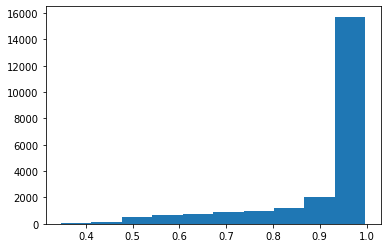

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(predictions_dict['predicted_scores'], bins=10)

## Explaining classification results using gradient-based input saliency maps

*Explainability*, also reffered to as *Interpretability* of a machine learning model refers to the ability to determine the cause and effect relationship between the inputs of a model and its prediction. It allows a human user to understand and explain the decision of a model. It also allows knowledge discovery (spot specific patterns in the data) and helps debug the model, for example, to better understand incorrect predictions.

Gradient-based input saliency methods is used to find out which input tokens (sub-words) are the most important for a given prediction made by the model.

For a given prediction, the importance of each input token is obtained by calculating the gradient of the score (value of the output logit) corresponding to the predicted class, with respect to the inputs. Specifically, the smallest change in the input token with the highest gradient-based saliency value will result in a large change in the output of the model. 
We use the *Gradient X Input* method in which the computed gradient vector per token is multiplied by the input embedding of the token. Taking the $L2$ norm of the resulting vector gives the token's feature importance score, a measure of how sensitive the model is to that specific input token. More formally, the importance of the token at the $i^{th}$ position in the input sequence is given by:
<p style="text-align: center;"> 
    $\left \| \nabla_{X_{i}} f_{c}(X_{1:n}) \cdot X_{i} \right \|_{2}$
</p>
where $X_{i}$ is the embedding vector of the $i^{th}$ input token, $X_{1:n}$ is the list of embedding vectors of all the tokens in the input sequence (of length $n$), $f_{c}(X_{1:n})$ is the score of the predicted class after a forward pass through the model, $\nabla_{X_{i}} f_{c}(X_{1:n})$ is the back-propagated gradient of the score of the predicted class.


In [40]:
from torch.utils.data import DataLoader
import torch

#load a batch of 16 test samples
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

test_batch = next(iter(test_loader))
input_ids = test_batch['input_ids']
attention_mask = test_batch['attention_mask']
labels = test_batch['encoded_labels']

classifier.predict(test_batch)


{'predicted_labels': tensor([2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'predicted_scores': tensor([0.9961, 0.9798, 0.9803, 0.9840, 0.9921, 0.9964, 0.8504, 0.8156, 0.9939,
         0.9950, 0.9804, 0.9849, 0.8253, 0.9949, 0.9948, 0.9807],
        grad_fn=<MaxBackward0>)}

Visualizing the connectivity tensor obtained when predicting the class of a specific vulnerability description in the batch. The connectivity tensor contains the importance score of each input token for a vulnerability description.

In [49]:
from explainable_bert_classifier.input_saliency_maps import connectivity_tensor_computation

idx = 10 #index in the batch of the vulnerability to analyze
connectivity_tensor_computation(classifier.model, input_ids[idx], attention_mask[idx], verbose=True)

input grad variable: None
output logits: tensor([[ 3.4673, -0.4992, -3.4166]], grad_fn=<AddmmBackward>)
predicted label (after softmax): 0
score for predicted label (after softmax): 0.9804266691207886
input grad variable: tensor([[-0.0077,  0.0132,  0.0011,  ..., -0.0039, -0.0055, -0.0235],
        [-0.0722, -0.0150,  0.0241,  ..., -0.0907, -0.1056,  0.0477],
        [ 0.0202,  0.0081,  0.0301,  ...,  0.0226,  0.0087,  0.0112],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


tensor([0.1480, 0.8103, 0.1246, 0.0362, 0.1025, 0.0359, 0.0877, 0.1018, 0.0741,
        0.0281, 0.0281, 0.0234, 0.0261, 0.1407, 0.0295, 0.0358, 0.0612, 0.0143,
        0.0665, 0.0183, 0.0292, 0.0319, 0.0173, 0.1188, 0.0377, 0.0253, 0.0773,
        0.0274, 0.0789, 0.0236, 0.0278, 0.0209, 0.0328, 0.0426, 0.0331, 0.0313,
        0.0376, 0.0287, 0.0518, 0.0243, 0.0221, 0.0197, 0.0183, 0.0395, 0.0448,
        0.0280, 0.0447, 0.0312, 0.0567, 0.0368, 0.0302, 0.0350, 0.0209, 0.1517,
        0.0184, 0.0213, 0.0309, 0.0369, 0.0245, 0.0238, 0.0524, 0.0259, 0.0265,
        0.0483, 0.0224, 0.1540, 0.0227, 0.0360, 0.0336, 0.0472, 0.0639, 0.0759,
        0.4462, 0.0449, 0.0867, 0.0532, 0.0484, 0.1815, 0.1971, 0.1462, 0.2402,
        0.1867, 0.9692, 1.0000, 0.0954, 0.3056, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

*top_k_tokens* takes as input a vulnerability description and returns the list of input tokens (tokenized representation of the description) along with the indices, the values and the connectivities of the top k tokens.

In [50]:
from explainable_bert_classifier.input_saliency_maps import top_k_tokens

top_k_tokens(test_batch['vulnerability_description'][idx], mytokenizer, classifier.model, k=5)

{'input_tokens': ['[CLS]',
  'adobe',
  'ac',
  '##ro',
  '##bat',
  'and',
  'reader',
  'versions',
  '2019',
  '.',
  '01',
  '##2',
  '.',
  '2003',
  '##5',
  'and',
  'earlier',
  ',',
  '2019',
  '.',
  '01',
  '##2',
  '.',
  '2003',
  '##5',
  'and',
  'earlier',
  ',',
  '2017',
  '.',
  '01',
  '##1',
  '.',
  '301',
  '##42',
  'and',
  'earlier',
  ',',
  '2017',
  '.',
  '01',
  '##1',
  '.',
  '301',
  '##43',
  'and',
  'earlier',
  ',',
  '2015',
  '.',
  '00',
  '##6',
  '.',
  '304',
  '##9',
  '##7',
  'and',
  'earlier',
  ',',
  'and',
  '2015',
  '.',
  '00',
  '##6',
  '.',
  '304',
  '##9',
  '##8',
  'and',
  'earlier',
  'have',
  'an',
  'integer',
  'over',
  '##flow',
  'vulnerability',
  '.',
  'successful',
  'exploitation',
  'could',
  'lead',
  'to',
  'information',
  'disclosure',
  '.',
  '[SEP]'],
 'top_k_tokens': ['disclosure', 'information', 'adobe', 'integer', '[SEP]'],
 'top_k_indices': [83, 82, 1, 72, 85],
 'top_k_connectivity_weight': [1.0,


*print_texts_with_top_influential_words_in_bold* print the vulnerability descriptions with the top_k relevant tokens in bold.

In [51]:
from explainable_bert_classifier.input_saliency_maps import print_texts_with_top_influential_words_in_bold

_ = print_texts_with_top_influential_words_in_bold(test_batch['vulnerability_description'][idx], mytokenizer, classifier.model, k=5)

Adobe Acrobat and Reader versions 2019.012.20035 and earlier, 2019.012.20035 and earlier, 2017.011.30142 and earlier, 2017.011.30143 and earlier, 2015.006.30497 and earlier, and 2015.006.30498 and earlier have an integer overflow vulnerability. Successful exploitation could lead to information disclosure.


For each instance of *test_batch*, printing the predicted label and the confidence score (vaue of the logit of the predicted class after softmax), followed by the vulnerability description with top relevant tokens in bold.

In [53]:
from explainable_bert_classifier.input_saliency_maps import print_texts_with_top_influential_words_in_bold

predictions = classifier.predict(test_batch)
cat_classes = ['HIGH', 'LOW', 'NONE']

for description, label, score in zip( test_batch['vulnerability_description'], predictions['predicted_labels'], predictions['predicted_scores'] ):
    print('--------------------------------------------------------------------------------------------')
    print('Predicted Confidentiality Impact: ', cat_classes[label])
    print('Confidence: ', score)
    _ = print_texts_with_top_influential_words_in_bold(description, mytokenizer, classifier.model)

--------------------------------------------------------------------------------------------
Predicted Confidentiality Impact:  NONE
Confidence:  tensor(0.9961, grad_fn=<UnbindBackward>)
In Ceph before 12.2.3 and 13.x through 13.0.1, the rgw_civetweb.cc RGWCivetWeb::init_env function in radosgw doesn't handle malformed HTTP headers properly, allowing for denial of service.
--------------------------------------------------------------------------------------------
Predicted Confidentiality Impact:  HIGH
Confidence:  tensor(0.9798, grad_fn=<UnbindBackward>)
An elevation of privilege vulnerability exists when the Windows Update Orchestrator Service improperly handles file operations, aka 'Windows Update Orchestrator Service Elevation of Privilege Vulnerability'. This CVE ID is unique from CVE-2020-0868.
--------------------------------------------------------------------------------------------
Predicted Confidentiality Impact:  HIGH
Confidence:  tensor(0.9803, grad_fn=<UnbindBackward>)
